# Experiment 3: Choosing between earlier and later labels for blue + naive members

January 2025 

In [1]:
import numpy as np
from memo import memo

import jax
import jax.numpy as jnp
import optax
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from enum import IntEnum

import utils

sns.set_context('poster', font_scale=1.3)

## Load data and fit model

In [2]:
data = pd.read_csv("../data/3pp/varied_audience/selection_trials_clean.csv"
                   ).rename(columns={"item_id": "tangram_set"})

data.loc[data["response.earlier"] == "earlier", "response.earlier"] = 1
data.loc[data["response.earlier"] == "later", "response.earlier"] = 0
data["response.earlier"] = data["response.earlier"].astype(int)

Get the relevant stuff from the data

In [3]:
refer_mask = data["goal"] == "refer"
social_mask = data["goal"] == "social"

# Convert columns for the 'refer' subset
n_in_refer = jnp.array(data.loc[refer_mask, "n_ingroup"].values)
n_out_refer = jnp.array(data.loc[refer_mask, "n_outgroup"].values)
resp_refer = jnp.array(data.loc[refer_mask, "response.earlier"].values)

# Convert columns for the 'social' subset
n_in_social = jnp.array(data.loc[social_mask, "n_ingroup"].values)
n_out_social = jnp.array(data.loc[social_mask, "n_outgroup"].values)
resp_social = jnp.array(data.loc[social_mask, "response.earlier"].values)

### Model

In [4]:
# type: ignore
class Choices(IntEnum):
    Later = 0
    Earlier = 1


class is_noisy(IntEnum):
    No = 0
    Yes = 1


@jax.jit
def ref_info(n_ingroup, n_outgroup, utterance):
    earlier_utility = n_ingroup + n_outgroup
    later_utility = n_ingroup
    return jnp.array([later_utility, earlier_utility])[utterance]


@jax.jit
def social_info(n_ingroup, n_outgroup, utterance):
    earlier_utility = 0
    later_utility = n_ingroup  # 1
    return jnp.array([later_utility, earlier_utility])[utterance]


@jax.jit
def cost(utterance):
    return jnp.array([0, 1])[utterance]


@jax.jit
def is_noisy_wpp(noisy, p_noise):
    return jnp.array([1 - p_noise, p_noise])[noisy]


@memo
def speaker[
    utterance: Choices, noisy: is_noisy
](n_ingroup, n_outgroup, alpha, w_r, w_s, w_c, p_noise):
    cast: [speaker]
    speaker: chooses(noisy in is_noisy, wpp=is_noisy_wpp(noisy, p_noise))

    speaker: chooses(
        utterance in Choices,
        wpp=exp(
            alpha
            * (
                (1 - noisy)
                * (
                    w_r * ref_info(n_ingroup, n_outgroup, utterance)
                    + w_s * social_info(n_ingroup, n_outgroup, utterance)
                    - w_c * cost(utterance)
                )
                + noisy * 0
            )
        ),
    )
    return Pr[speaker.utterance == utterance]

Model speaker functions

In [5]:
# type: ignore
@jax.jit
def speaker_refer(n_ingroup, n_outgroup, w_r, w_c, p_noise):
    return speaker(
        n_ingroup=n_ingroup,
        n_outgroup=n_outgroup,
        alpha=1,
        w_r=w_r,
        w_s=0,
        w_c=w_c,
        p_noise=p_noise,
    )[1, 0]

@jax.jit
def speaker_social(n_ingroup, n_outgroup, w_r, w_s, w_c, p_noise):
    return speaker(
        n_ingroup=n_ingroup,
        n_outgroup=n_outgroup,
        alpha=1,
        w_r=0,
        w_s=w_s,
        w_c=w_c,
        p_noise=p_noise,
    )[1, 0]

# functions for generating predictions over the whole dataset
speaker_refer_vmap = jax.vmap(speaker_refer, in_axes=(0, 0, None, None, None))
speaker_social_vmap = jax.vmap(speaker_social, in_axes=(0, 0, None, None, None, None))

Compute preds on the whole dataset

In [6]:
@jax.jit
def predict_all(model_type, n_in_refer, n_out_refer, n_in_social, n_out_social, w_r, w_s, w_c, p_noise):
    preds_refer = speaker_refer_vmap(n_in_refer, n_out_refer, w_r, w_c, p_noise)
    preds_social = jax.lax.cond(
        model_type == utils.ModelType.social,
        lambda _: speaker_social_vmap(n_in_social, n_out_social, w_r, w_s, w_c, p_noise),
        lambda _: speaker_refer_vmap(n_in_social, n_out_social, w_r, w_c, p_noise),
        operand=None
    )
    return preds_refer, preds_social

@jax.jit
def NLL_all(model_type, n_in_refer, n_out_refer, n_in_social, n_out_social, resp_refer, resp_social, w_r, w_s, w_c, p_noise):
    preds_refer, preds_social = predict_all(model_type, n_in_refer, n_out_refer, n_in_social, n_out_social, w_r, w_s, w_c, p_noise)
    nll_refer = utils.compute_NLL(preds_refer, resp_refer)
    nll_social = utils.compute_NLL(preds_social, resp_social)
    return nll_refer + nll_social

In [7]:
def fit_params(
    model_type,
    initial_params,
    n_in_refer,
    n_out_refer,
    n_in_social,
    n_out_social,
    resp_refer,
    resp_social,
    lr=0.001,
    tol=1e-6,
    max_steps=10000,
):
    def loss_fn(params):
        return NLL_all(
            model_type,
            n_in_refer,
            n_out_refer,
            n_in_social,
            n_out_social,
            resp_refer,
            resp_social,
            params[0],
            params[1],
            params[2],
            params[3]
        )

    grad_fn = jax.value_and_grad(loss_fn)
    params = jnp.array(initial_params, dtype=jnp.float32)
    optimizer = optax.adam(learning_rate=lr)
    opt_state = optimizer.init(params)

    prev_nll = None
    for step in range(max_steps):
        nll_value, nll_grads = grad_fn(params)
        updates, opt_state = optimizer.update(nll_grads, opt_state)
        params = optax.apply_updates(params, updates)
        params = params.at[3].set(jnp.clip(params[3], 0, 1)) # clip p_noise to [0, 1] 
        # ensure all other params are positive
        params = params.at[0:3].set(jnp.clip(params[0:3], 0, jnp.inf))

        if step % 1000 == 0:
            print(f"Step {step}, NLL value: {nll_value}, Params: {params}")

        if prev_nll is not None and abs(nll_value - prev_nll) < tol:
            print(f"Converged at step {step} with NLL={nll_value}, Params={params}")
            break

        prev_nll = nll_value

    best_nll = loss_fn(params)
    return params, best_nll

In [8]:
best_params_social, best_nll_social = fit_params(
    utils.ModelType.social,
    [1, 1, 1, 0.1],
    n_in_refer,
    n_out_refer,
    n_in_social,
    n_out_social,
    resp_refer,
    resp_social,
    lr=0.0001,
    tol=1e-6,
    max_steps=100000,
)
best_w_r_social, best_w_s_social, best_w_c_social, best_p_noise_social = best_params_social

Step 0, NLL value: 7197.8818359375, Params: [1.0001 0.9999 0.9999 0.1001]
Step 1000, NLL value: 6453.0791015625, Params: [1.1131053  0.90884    0.90926147 0.1847716 ]
Step 2000, NLL value: 6101.6162109375, Params: [1.2166586  0.82566506 0.83037376 0.2528466 ]
Step 3000, NLL value: 5900.505859375, Params: [1.3101854  0.7445845  0.7579743  0.31190008]
Step 4000, NLL value: 5782.7265625, Params: [1.3983306  0.66418844 0.69035554 0.3628916 ]
Step 5000, NLL value: 5717.20166015625, Params: [1.4834036 0.5843113 0.6276943 0.4037811]
Step 6000, NLL value: 5682.9296875, Params: [1.5656861  0.50470394 0.57163507 0.43016917]
Step 7000, NLL value: 5662.8134765625, Params: [1.6437104  0.4241614  0.52578187 0.43698597]
Step 8000, NLL value: 5646.70703125, Params: [1.714219   0.3417887  0.49978015 0.4245668 ]
Step 9000, NLL value: 5633.712890625, Params: [1.7748405  0.26147056 0.5189253  0.40444642]
Step 10000, NLL value: 5624.1455078125, Params: [1.8331269  0.18906741 0.5955297  0.3900042 ]
Step 110

In [9]:
best_params_base, best_nll_base = fit_params(
    utils.ModelType.base,
    [1, 0, 1, 0.1],
    n_in_refer,
    n_out_refer,
    n_in_social,
    n_out_social,
    resp_refer,
    resp_social,
    lr=0.001,
    tol=1e-6,
    max_steps=10000,
)
best_w_r_base, best_w_s_base, best_w_c_base, best_p_noise_base = best_params_base

Step 0, NLL value: 8177.41650390625, Params: [0.999 0.    1.001 0.101]
Step 1000, NLL value: 6333.15234375, Params: [0.70163924 0.         1.1039755  0.5357518 ]
Step 2000, NLL value: 6282.59716796875, Params: [0.923621  0.        1.2300122 0.6499409]
Step 3000, NLL value: 6268.1279296875, Params: [1.2138702  0.         1.5224826  0.66941416]
Step 4000, NLL value: 6258.4970703125, Params: [1.5212252  0.         1.8262768  0.67780966]
Step 5000, NLL value: 6252.7099609375, Params: [1.8255631  0.         2.1057825  0.68451035]
Step 6000, NLL value: 6249.35693359375, Params: [2.1230438 0.        2.348946  0.6901916]
Converged at step 6568 with NLL=6247.9287109375, Params=[2.3246791 0.        2.4493854 0.6934168]


Generate model predictions (one for each data point)

In [10]:
preds_refer_social, preds_social_social = predict_all(
    model_type=utils.ModelType.social,
    n_in_refer=n_in_refer,
    n_out_refer=n_out_refer,
    n_in_social=n_in_social,
    n_out_social=n_out_social,
    w_r=best_w_r_social,
    w_s=best_w_s_social,
    w_c=best_w_c_social, 
    p_noise = best_p_noise_social
)

preds_refer_base, preds_social_base = predict_all(
    model_type=utils.ModelType.base,
    n_in_refer=n_in_refer,
    n_out_refer=n_out_refer,
    n_in_social=n_in_social,
    n_out_social=n_out_social,
    w_r=best_w_r_base,
    w_s=best_w_s_base,
    w_c=best_w_c_base, 
    p_noise = best_p_noise_base
)


Put preds together in a dataframe

In [11]:
preds_df_social = pd.concat(
    [
        pd.DataFrame(
            {
                "model": "social model",
                "goal": "refer",
                "n_ingroup": n_in_refer,
                "n_outgroup": n_out_refer,
                "p_earlier": preds_refer_social,
            }
        ),
        pd.DataFrame(
            {
                "model": "social model",
                "goal": "social",
                "n_ingroup": n_in_social,
                "n_outgroup": n_out_social,
                "p_earlier": preds_social_social,
            }
        ),
    ]
)

preds_df_base = pd.concat(
    [
        pd.DataFrame(
            {
                "model": "base model",
                "goal": "refer",
                "n_ingroup": n_in_refer,
                "n_outgroup": n_out_refer,
                "p_earlier": preds_refer_base,
            }
        ),
        pd.DataFrame(
            {
                "model": "base model",
                "goal": "social",
                "n_ingroup": n_in_social,
                "n_outgroup": n_out_social,
                "p_earlier": preds_social_base,
            }
        ),
    ]
)


preds_df = pd.concat([preds_df_social, preds_df_base])

preds_df["prop_naive"] = preds_df["n_outgroup"] / (
    preds_df["n_outgroup"] + preds_df["n_ingroup"]
)
data["model"] = "data"
data["prop_naive"] = data["n_outgroup"] / (data["n_outgroup"] + data["n_ingroup"])
data = data.rename(columns={"response.earlier": "p_earlier"})
data_df = data[["model", "goal", "n_ingroup", "n_outgroup", "p_earlier", "prop_naive"]]
preds_df = pd.concat([preds_df, data_df])
preds_df

,model,goal,n_ingroup,n_outgroup,p_earlier,prop_naive
0,social model,refer,0,1,0.667776,1.000000
1,social model,refer,3,8,0.808339,0.727273
2,social model,refer,2,16,0.808339,0.888889
3,social model,refer,2,2,0.787340,0.500000
4,social model,refer,1,4,0.808029,0.800000
...,...,...,...,...,...,...
9482,data,refer,2,0,1.000000,0.000000
9483,data,social,4,1,1.000000,0.200000
9484,data,social,2,16,1.000000,0.888889
9485,data,refer,1,2,1.000000,0.666667


## Plot

In [12]:
conditions = [
    (preds_df["goal"] == "refer") & (preds_df["n_outgroup"] == 0),
    (preds_df["goal"] == "refer") & (preds_df["n_outgroup"] > 0),
    (preds_df["goal"] == "social")
]
conditions_labels = ["refer to in-group", "refer to mixed", "social"]
preds_df["condition"] = np.select(conditions, conditions_labels)

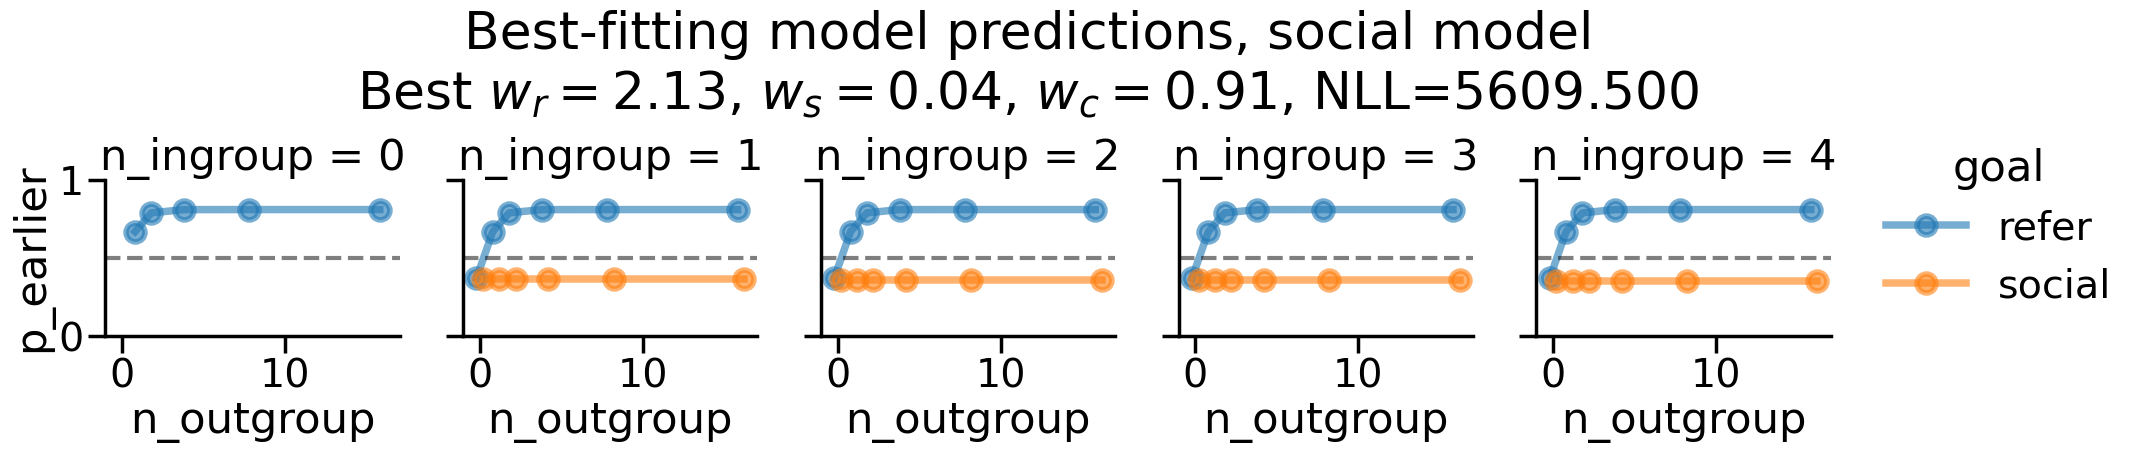

In [13]:
g = sns.catplot(
    data=preds_df[preds_df["model"] == "social model"],
    x="n_outgroup",
    y="p_earlier",
    hue="goal",
    col="n_ingroup",
    kind="point",
    dodge=0.4,
    alpha=0.6,
    col_wrap=5,
    height=4,
    native_scale=True,
    log_scale=(False, False),
)
g.map(plt.axhline, y=0.5, ls="--", color="black", alpha=0.5)
g.set(ylim=(0, 1))
g.figure.suptitle(
    "Best-fitting model predictions, social model\nBest $w_r= {:.2f}$, $w_s= {:.2f}$, $w_c= {:.2f}$, NLL={:.3f}".format(
        best_w_r_social, best_w_s_social, best_w_c_social, best_nll_social
    ),
    y=1.2,
)
plt.show()

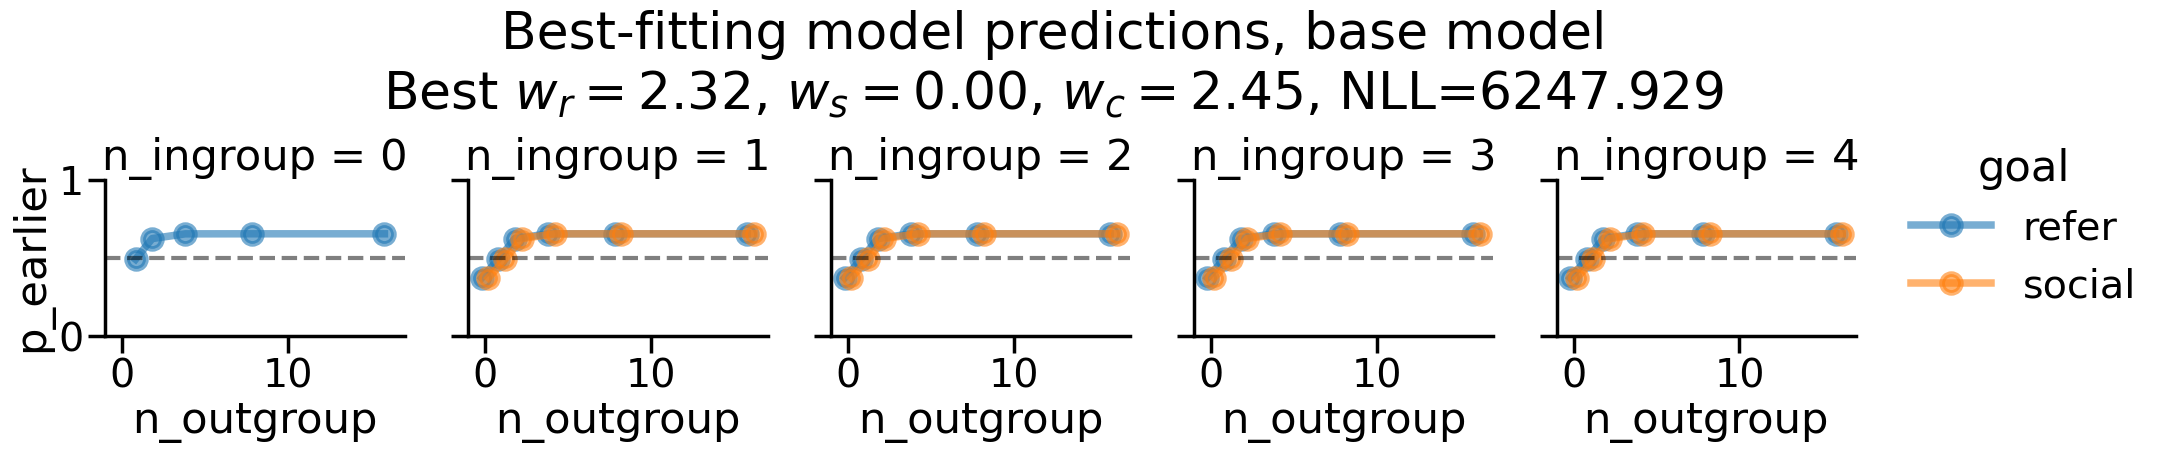

In [14]:
g = sns.catplot(
    data=preds_df[preds_df["model"] == "base model"],
    x="n_outgroup",
    y="p_earlier",
    hue="goal",
    col="n_ingroup",
    kind="point",
    dodge=0.4,
    alpha=0.6,
    col_wrap=5,
    height=4,
    native_scale=True,
    log_scale=(False, False),
)
g.map(plt.axhline, y=0.5, ls="--", color="black", alpha=0.5)
g.set(ylim=(0, 1))
g.figure.suptitle(
    "Best-fitting model predictions, base model\nBest $w_r= {:.2f}$, $w_s= {:.2f}$, $w_c= {:.2f}$, NLL={:.3f}".format(
        best_w_r_base, best_w_s_base, best_w_c_base, best_nll_base
    ),
    y=1.2,
)
plt.show()

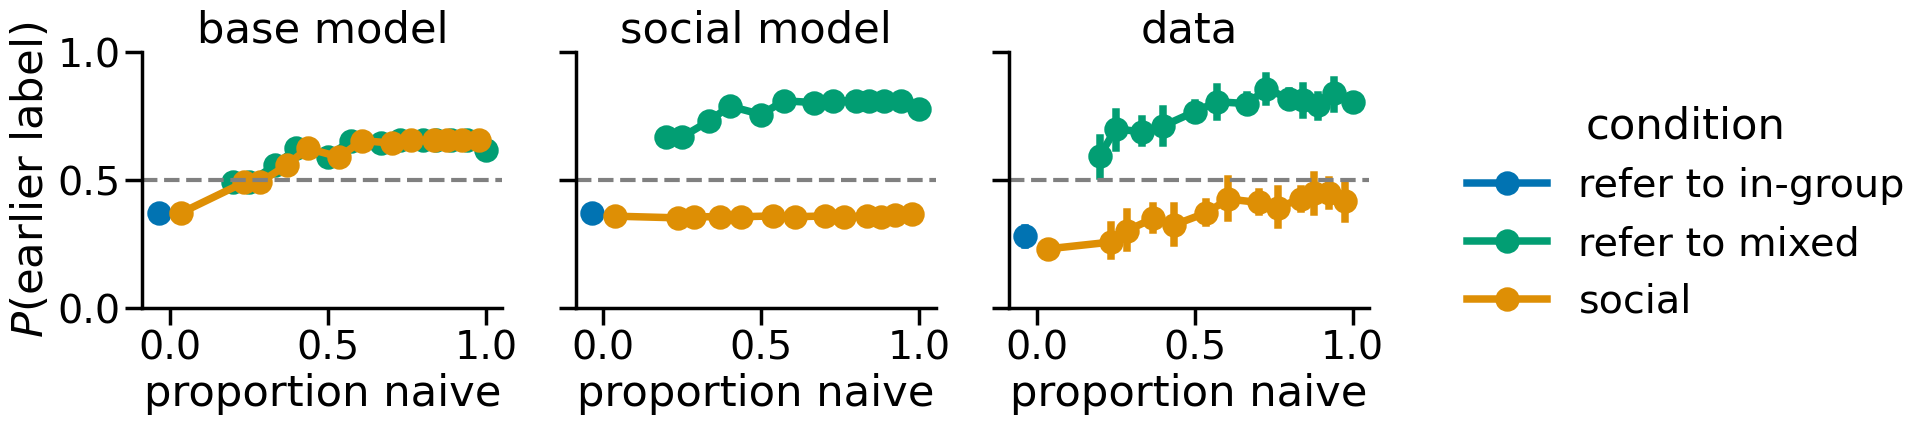

In [15]:
g = sns.FacetGrid(
    preds_df,
    col="model", 
    col_order=["base model", "social model", "data"],
    margin_titles=True,
    height=5,
    aspect=1.05
)
g.map_dataframe(
    sns.pointplot,
    x="prop_naive",
    y="p_earlier",
    hue="condition",
    hue_order=conditions_labels,
    palette=utils.palette,
    dodge=1.7,
    alpha=1, 
    native_scale=True
)
g.set_titles(col_template="{col_name}", row_template="{row_name} label")
g.set(ylim=(0, 1), ylabel="$P(\\text{earlier label})$", xlabel="proportion naive")
for ax in g.axes.flat:
    ax.axhline(0.5, ls="--", color="gray")
g.add_legend(title="condition", bbox_to_anchor=(1.01, 0.5))
plt.savefig(utils.fig_dir + "3pp_blue_naive_earlier_later.pdf")

plt.show()

Likelihood ratio test

In [16]:
from scipy.stats import chi2
lr_stat = 2 * (best_nll_base - best_nll_social)
df = 1
p = 1 - chi2.cdf(lr_stat, df)
print(f"LR test: χ²({df}) = {lr_stat}, p = {p}")

LR test: χ²(1) = 1276.857421875, p = 0.0
